In [1]:
from rw_ve_plot import *
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('RW_visualization.mplstyle')


In [2]:
# import warnings filter
from pandas.errors import SettingWithCopyWarning
import warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


Load data

In [3]:
# df1 = pd.read_excel(r'C:\Users\dipes\python\jupyter_notebook_files\Vaccine details.xlsx')
vaccine_detail = pd.read_excel('vaccine_details.xlsx')
vaccine_detail.columns = vaccine_detail.columns.str.strip().str.lower().str.replace(' ', '_').\
    str.replace('(', '').str.replace(')', '')

# Remove all vaccine rows
vaccine_detail = vaccine_detail[~(vaccine_detail['vaccine']=='All vaccine')]

vaccine_detail['method_to_calculate_ve'] = vaccine_detail['method_to_calculate_ve'].replace('1- adj relative risk', '1-relative risk') 


C:\Users\GIGABYTE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Calculate vaccine efficacy and CIs by relative risk and poission regression with robust error variance if no 0 in each group

In [4]:
# Calculate vaccine efficacy and confidence interval
RW_vaccine_efficacy = np.ones(len(vaccine_detail))*np.nan
RW_lower = np.ones(len(vaccine_detail))*np.nan
RW_higher = np.ones(len(vaccine_detail))*np.nan
for i, row in vaccine_detail.iterrows():
    xv = row['no_of_participants_in_vaccine_group']
    xp = row['no_of_participants_in_placebo_groupcontrol_group']
    xve = row['no_of_infected_in_vaccine_group']
    xpe = row['no_of_infected_in_placebo_group']
    if xve != 'X':
        # Relative risk
        r1 = xve/xv
        r2 = xpe/xp
        theta = r1/r2
        VE = 1-theta
        RW_vaccine_efficacy[i] = VE
        if (xve != 0) & (xpe != 0):
            # Poisson regression with robust error variance
            variance = 1/xve - 1/xv + 1/xpe - 1/xp
            se = np.sqrt(variance)
            RW_lower[i] = 1-theta*np.exp(1.96*se)
            RW_higher[i] = 1-theta*np.exp(-1.96*se)
        else:
            RW_lower[i] = 0
            RW_higher[i] = 0


In [5]:
# Append my result to the table
vaccine_detail['RW_efficacy_in_%'] = RW_vaccine_efficacy*100
vaccine_detail['RW_lower'] = RW_lower*100
vaccine_detail['RW_upper'] = RW_higher*100

vaccine_detail.to_excel('rw_vaccine_details.xlsx')


In [6]:
# Extract references array
import re
references = np.array([])
for i in vaccine_detail['reference'].str.split('_'):
    reference = i[0]
    reference = re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " et al. ", reference)
    references = np.append(references, reference)

In [7]:
# Correct article's vaccine efficacy label
for i in range(len(vaccine_detail)):
    efficacy_method = vaccine_detail.method_to_calculate_ve.loc[i]
    for j, word in enumerate(efficacy_method):
        if word.isalpha() == True:
            efficacy_method = efficacy_method[j::]
            efficacy_method = efficacy_method[0].upper() + efficacy_method[1::]
            vaccine_detail.method_to_calculate_ve.loc[i] = efficacy_method
            break

paper_ve_methods = vaccine_detail.method_to_calculate_ve.to_numpy()
paper_ve_methods[paper_ve_methods == 'X'] = 'Not specify'

In [8]:
# Correct article's CI label
for i in range(len(vaccine_detail)):
    CI = vaccine_detail.method_to_calculate_ci.loc[i]
    CI = CI[0].upper() + CI[1::]
    vaccine_detail.method_to_calculate_ci.loc[i] = CI

paper_ci_methods = vaccine_detail.method_to_calculate_ci.to_numpy()
paper_ci_methods[paper_ci_methods == 'X'] = 'Not specify'
# paper_ci_methods[paper_ci_methods ==
#                  "Stratified Cox proportional-hazards model with Efron's method of tie handling"] = 'Cox proportional-hazards'
# paper_ci_methods[paper_ci_methods == 'Poisson regression with robust error variance'] = 'Poisson regression'

Plot my CIs vs paper's CIs

In [9]:
vaccine_detail.columns


Index(['vaccine', 'variant', 'efficacy_in_%', 'lower', 'upper',
       'no_of_participants_in_vaccine_group',
       'no_of_participants_in_placebo_groupcontrol_group',
       'no_of_infected_in_vaccine_group', 'no_of_infected_in_placebo_group',
       'observation_period_in_weeks', 'person_time_vaccine',
       'person_time_placebo', 'trial_start_date',
       'trial_enrollemement_period_in_days', 'coutry', 've_type', 'ave',
       'score', 'method_to_calculate_ve', 'method_to_calculate_ci',
       'study_type', 'type_of_article', 'reference', 'unnamed:_23',
       'RW_efficacy_in_%', 'RW_lower', 'RW_upper'],
      dtype='object')

In [10]:
# Clean nan
RW_vaccine_efficacy = vaccine_detail['RW_efficacy_in_%'].to_numpy()
nan_map = np.isnan(RW_vaccine_efficacy)
RW_vaccine_efficacy = RW_vaccine_efficacy[~nan_map]

paper_vaccine_efficacy = vaccine_detail['efficacy_in_%'].to_numpy()
paper_vaccine_efficacy = paper_vaccine_efficacy[~nan_map]


paper_lower_bound = vaccine_detail['lower'].to_numpy()
paper_lower_bound[paper_lower_bound == 'X'] = 0
paper_lower_bound = paper_lower_bound[~nan_map]

paper_upper_bound = vaccine_detail['upper'].to_numpy()
paper_upper_bound[paper_upper_bound == 'X'] = 0
paper_upper_bound = paper_upper_bound[~nan_map]

RW_vaccine_efficacy = vaccine_detail['RW_efficacy_in_%'].to_numpy()
RW_vaccine_efficacy = RW_vaccine_efficacy[~nan_map]

RW_lower_bound = vaccine_detail['RW_lower'].to_numpy()
RW_lower_bound = RW_lower_bound[~nan_map]

RW_upper_bound = vaccine_detail['RW_upper'].to_numpy()
RW_upper_bound = RW_upper_bound[~nan_map]

paper_ve_methods = paper_ve_methods[~nan_map]
paper_ci_methods = paper_ci_methods[~nan_map]
references = references[~nan_map]

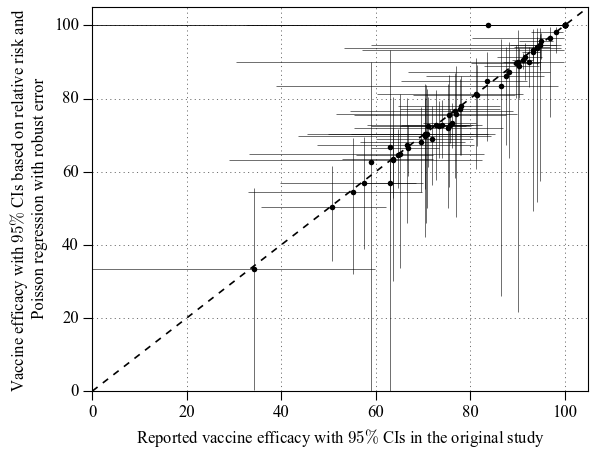

In [11]:
plot_compare_reproduced_vaccine_efficacy_scalar_plot(paper_vaccine_efficacy, paper_lower_bound, paper_upper_bound, \
    paper_ve_methods, paper_ci_methods, \
    RW_vaccine_efficacy, RW_lower_bound, RW_upper_bound, save_fig=False)

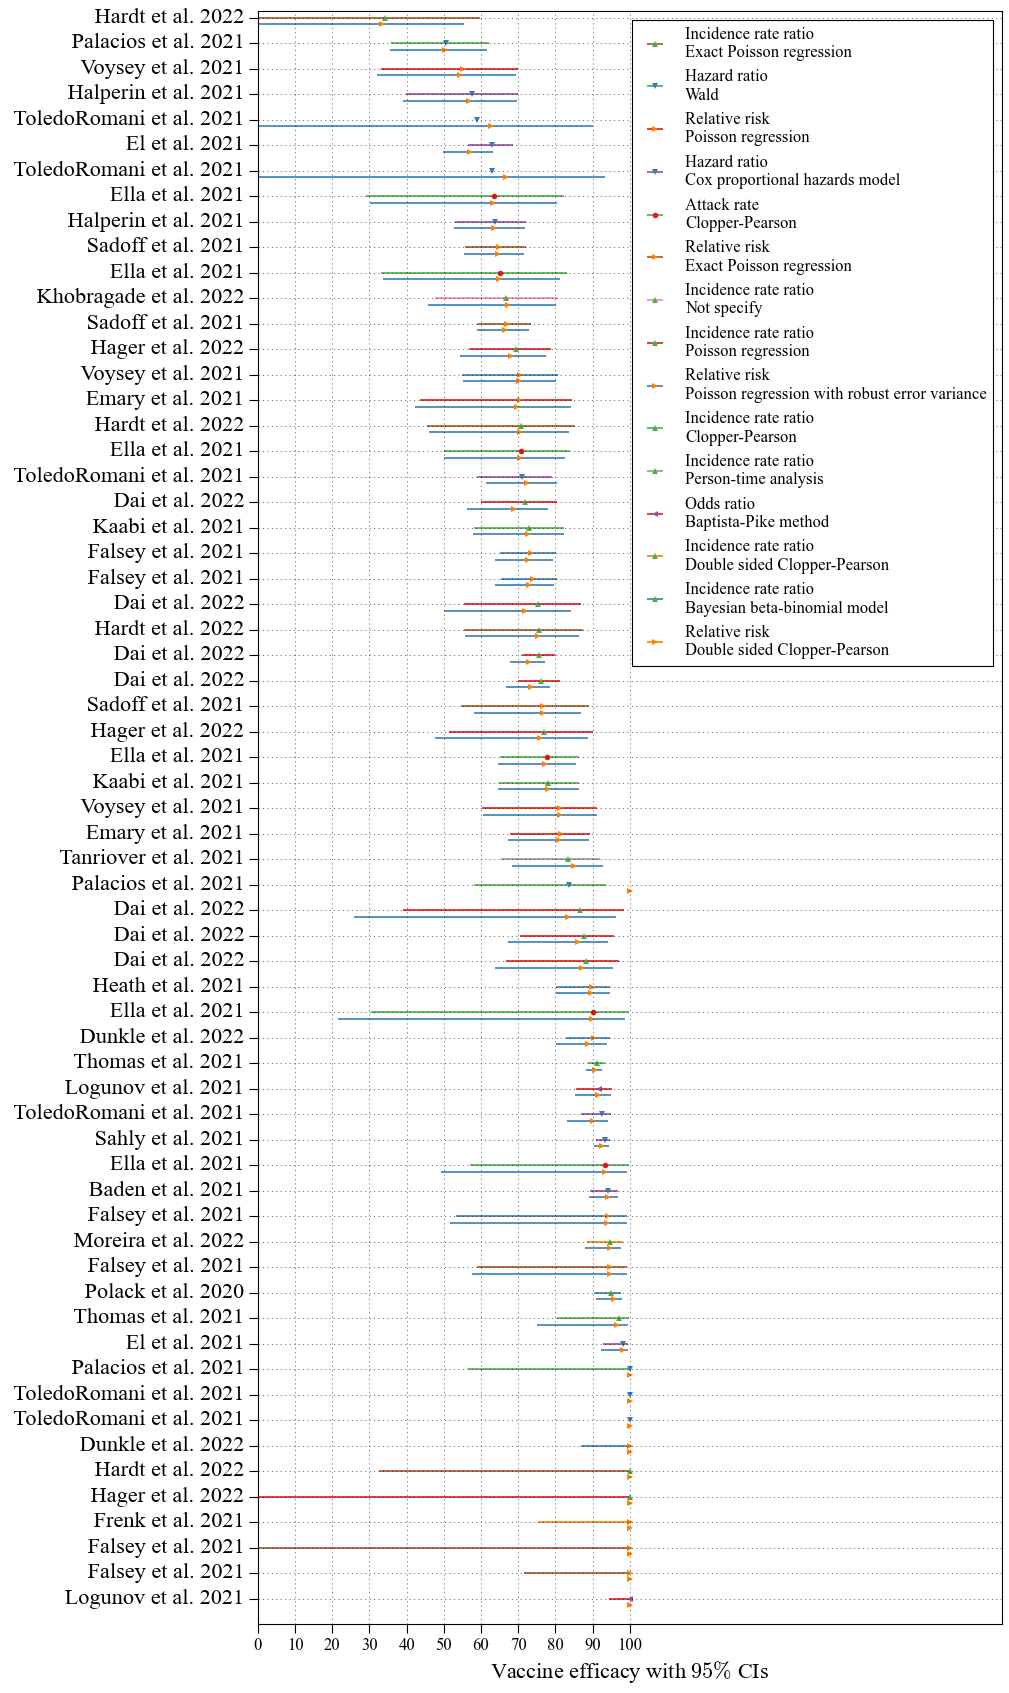

In [12]:
plot_compare_reproduced_vaccine_efficacy_error_bar_plot(paper_vaccine_efficacy, paper_lower_bound,
                                                            paper_upper_bound, paper_ve_methods, paper_ci_methods,
                                                            RW_vaccine_efficacy, RW_lower_bound, RW_upper_bound, 
                                                            references, save_fig=False)

In [13]:
print(f'Total number of recalibrated VE: {len(paper_vaccine_efficacy)}')
ve_difference = paper_vaccine_efficacy-RW_vaccine_efficacy
ve_index = np.argsort(ve_difference)

data = {'ve_difference': ve_difference, 'rw_ve': RW_vaccine_efficacy, 'paper_ve_methods': paper_ve_methods, 'paper_ci_methods': paper_ci_methods, 'reference': references}
df = pd.DataFrame(data)
print(df[abs(df['ve_difference']) > 3])


Total number of recalibrated VE: 63
    ve_difference       rw_ve      paper_ve_methods  \
3        3.091419   83.408581  Incidence rate ratio   
6        3.374108   71.825892  Incidence rate ratio   
42     -16.300000  100.000000          Hazard ratio   
46      -3.824392   66.824392          Hazard ratio   
47      -3.677441   62.677441          Hazard ratio   
56       5.963411   57.036589          Hazard ratio   

                  paper_ci_methods                  reference  
3               Poisson regression            Dai et al. 2022  
6               Poisson regression            Dai et al. 2022  
42                            Wald       Palacios et al. 2021  
46  Cox proportional hazards model   ToledoRomani et al. 2021  
47  Cox proportional hazards model   ToledoRomani et al. 2021  
56  Cox proportional hazards model             El et al. 2021  


In [14]:
np.unique(paper_ve_methods)

array(['Attack rate', 'Hazard ratio', 'Incidence rate ratio',
       'Odds ratio', 'Relative risk'], dtype=object)

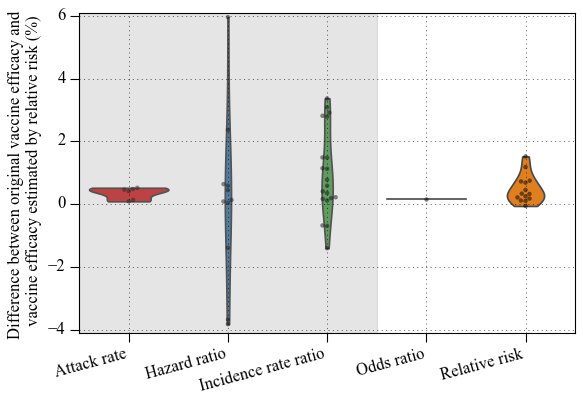

In [15]:
fig1 = different_between_efficacy(paper_vaccine_efficacy, paper_ve_methods, RW_vaccine_efficacy, save_fig=False)

C:\Users\GIGABYTE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:3544: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


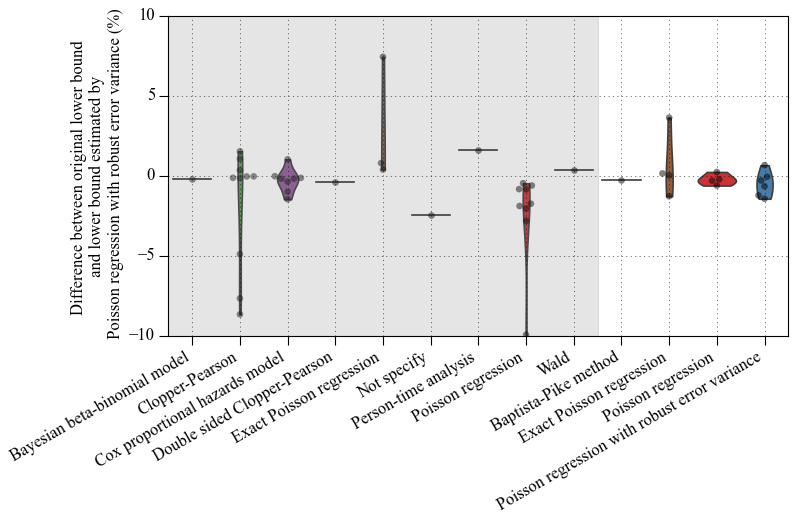

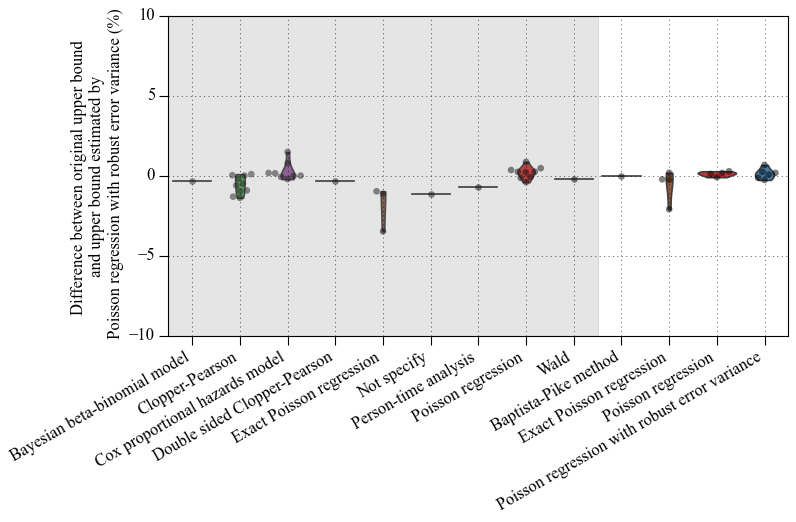

In [16]:
distance_between_CI(paper_vaccine_efficacy, paper_lower_bound,
                    paper_upper_bound, paper_ve_methods, paper_ci_methods,
                    RW_vaccine_efficacy, RW_lower_bound, RW_upper_bound,
                    save_fig=False)